In [1]:
# Figure 2

setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(tidyverse)
library(qs)

# data
meta_sub_LQ <- fread('metadata_subsample_LQ_no_id.txt', sep='\t', data.table=F) # low quality subsample metadata
meta_sub_HQ <- fread('metadata_subsample_HQ_no_id.txt', sep='\t', data.table=F) # high quality subsample metadata

meta_sub <- bind_rows(meta_sub_HQ, meta_sub_LQ) # combine HQ & LQ metadata


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()

qs v0.23.6.



In [2]:
## indexing 
# Lineage
epi.ind <- which(meta_sub$Lineage == "Epithelial_cells")
mes.ind <- which(meta_sub$Lineage == "Stromal_cells")
hem.ind <- which(meta_sub$Lineage == "Immune_cells")

# LQ cell type labels
tcell.ind.LQ <- which( meta_sub$hpca == "T_cells" )
bcell.ind.LQ <- which( meta_sub$hpca == "B_cell" )
macro.ind.LQ <- which( meta_sub$hpca == "Macrophage" | meta_sub$hpca == "Monocyte")
fibro.ind.LQ <- which( meta_sub$hpca == "Fibroblasts")

# LQ cell type labels
tcell.ind.HQ <- which( meta_sub$Celltype == "T cells" )
bcell.ind.HQ <- which( meta_sub$Celltype == "B cells" )
macro.ind.HQ <- which( meta_sub$Celltype == "Macrophages")
fibro.ind.HQ <- which( meta_sub$Celltype == "Fibroblasts")

# combined cell type labels
tcell.ind <- c(tcell.ind.LQ, tcell.ind.HQ)
bcell.ind <- c(bcell.ind.LQ, bcell.ind.HQ)
macro.ind <- c(macro.ind.LQ, macro.ind.HQ)
fibro.ind <- c(fibro.ind.LQ, fibro.ind.HQ)

## setting cut-offs
## JF's cut-off for FELINE_C1: > 1500 UMI. 500 - 7000 genes 
nCount_RNA_cutoff <- 1500
new.nCount_RNA_cutoff <- 450

all.retained <- length(which(meta_sub$nCount_RNA > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA )
epi.retained <- length(which(meta_sub$nCount_RNA[epi.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[epi.ind] )
mes.retained <- length(which(meta_sub$nCount_RNA[mes.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[mes.ind] )
hem.retained <- length(which(meta_sub$nCount_RNA[hem.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[hem.ind] )

tcell.retained <- length(which(meta_sub$nCount_RNA[tcell.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[tcell.ind] )
macro.retained <- length(which(meta_sub$nCount_RNA[macro.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[macro.ind] )
fibro.retained <- length(which(meta_sub$nCount_RNA[fibro.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[fibro.ind] )
bcell.retained <- length(which(meta_sub$nCount_RNA[bcell.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[bcell.ind] )


## Plot number of reads and genes by Cell type. Epithelial cells are used as a reference 

title.size <- 1.4
lab.size <- 1.0
sub.size <- 1.4

pdf('Figures/Fig.2.pdf', width = 14, height = 6)
par(mfrow=c(2,4), mar=c(6,5,5,1))


v <- list(epi.ind, mes.ind)
n <- list(epi.retained, mes.retained)
lapply( , FUN(v, n) {     
plot(main = "Epithelial cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[epi.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*epi.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[epi.ind])) ),)  # subtitle
},var2=n)


plot(main = "All cells: total reads (log10)", density(log10(meta_sub$nCount_RNA)), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*all.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA)) ),)  # subtitle

## Lineage plots
plot(main = "Epithelial cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[epi.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*epi.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[epi.ind])) ),)  # subtitle

plot(main = "Stromal cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[mes.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*mes.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[mes.ind])) ),)  # subtitle

plot(main = "Immune cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[hem.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*hem.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[hem.ind])) ),)  # subtitle

## Cell type plots
plot(main = "Fibroblasts: total reads (log10)", density(log10(meta_sub$nCount_RNA[fibro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*fibro.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[fibro.ind])) ),)  # subtitle

plot(main = "B-cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[bcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*bcell.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[bcell.ind])) ),)  # subtitle

plot(main = "T-cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[tcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*tcell.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[tcell.ind])) ),)  # subtitle

plot(main = "Macrophages/Monocytes: total reads (log10)", density(log10(meta_sub$nCount_RNA[macro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*macro.retained ),'%' ),)  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[macro.ind])) ),)  # subtitle




dev.off()
options(repr.plot.width=14, repr.plot.height=6)



pdf 
  2

In [3]:
options(warn=-1) # warnings off

# Figure 3
setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(ggridges)
library(ggpubr)
library(stringr)

# data
all.perf <- list.files(path = "/Users/ibishara/Desktop/FELINE_C1/", pattern = "SCN_Performance*", recursive = FALSE)  # create a list of raw count tables from all batches
perf.list.SCN <- lapply( all.perf, FUN = function(x) {fread(x, sep='auto')})
perf.SCN <- as.data.frame(do.call(rbind, perf.list.SCN))  #join list of tables 

all.perf <- list.files(path = "/Users/ibishara/Desktop/FELINE_C1/", pattern = "SR_Performance*", recursive = FALSE)  # create a list of raw count tables from all batches
perf.list.SR <- lapply( all.perf, FUN = function(x) {fread(x, sep='auto')})
perf.SR <- as.data.frame(do.call(rbind, perf.list.SR))  #join list of tables 

### deployment script
# SCN_Performance_summary_non_binary_Lineage <- fread("/Users/ibishara/Desktop/FELINE_C1/SCN_Performance_summary_non-binary_Lineage.txt", sep='auto')
# SCN_Performance_summary_floor_Lineage <- fread("/Users/ibishara/Desktop/FELINE_C1/SCN_Performance_summary_floor_Lineage.txt", sep='auto')

###

# distribution clean-up
# table_type = reads, genes
# method = poisson, non-binary, binary

dist.clean <- function(table_type, method){
    dist <- fread(paste('SCN_', table_type, '_distribution_', method, '.txt' , sep=''), sep = '\t') # read distribution table | same for SCN and SR

    # data clean-up
    dist$V1 <- NULL
    dist <- t(dist)
    colnames(dist) <- dist[1,]
    dist <- dist[-1,]
    dist <- melt(dist)
    dist <- dist[,-1]
    dist$value <- as.numeric(dist$value)
    return(dist)
}

dist.reads_poisson <- dist.clean('reads', 'poisson')
dist.genes_poisson <- dist.clean('genes', 'poisson')
dist.reads_nonbin <- dist.clean('reads', 'non-binary')
dist.genes_nonbin <- dist.clean('genes', 'non-binary')
dist.reads_binary <- dist.clean('reads', 'binary')
dist.genes_binary <- dist.clean('genes', 'binary')

# Calculates mean and median for plot annotations 
summ <- function(x) c(Mean = mean(x), median = median(x))
summ.clean <- function(mat) {
    stats <- aggregate(value ~  Var2, mat, summ, simplify = TRUE)
    stats <- cbind(stats[1], round(stats[[2]]))
    return(stats)
}

stat.reads_poisson <- summ.clean(dist.reads_poisson)
stat.genes_poisson <- summ.clean(dist.genes_poisson)
stat.reads_binary <- summ.clean(dist.reads_binary)
stat.genes_binary <- summ.clean(dist.genes_binary)
stat.reads_nonbin <- summ.clean(dist.reads_nonbin)
stat.genes_nonbin <- summ.clean(dist.genes_nonbin)


In [249]:


# train = 'SCN', 'SR'
# method = 'poisson', 'binary', 'non-binary'
# function plots the AUC at different thresholds of a 'train' algorithm and transformed by 'method'
AUCplot <- function(train, method) {
    if (train == 'SCN'){ 
        train = perf.SCN
        train.name <- 'SCN trained'

    } else if(train == 'SR') {
        train = perf.SR
        train.name <- 'SingleR trained'
        }

    # AUC plot    
    AUC_pROC <- as.numeric(train$AUC_pROC)
    data <- train[train$method == method,]
    data <- data[order(data$AUC_pROC),]

    main.levels <- levels(threshold)[12:length(levels(threshold))]  #c('0.6','0.7','0.8','0.9','1.0','1.5','2.0','3.0','4.0','untransformed')
    inset.levels <- levels(threshold)[1:11] #c('0.0','0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5')

    plot <- ggplot(data, aes(threshold, AUC_pROC )) + 
                theme_classic() + 
                theme(plot.title = element_text(vjust = 2, hjust = 0.5)) # center plot title

    main.plot <- plot +       
                geom_point(aes(color = as.factor(class)), size = 2, alpha = 0.8) + 
                scale_x_discrete(breaks=main.levels, limits=main.levels) +
                ylim(min(data$AUC_pROC[22:42]*0.9), max(data$AUC_pROC[22:42])) +
                xlab("threshold (x1000)") + ylab("AUROCC") + labs(color='Class')  +
                ggtitle(paste(train.name, "transformed", method, sep =' - ')) 


    inset.plot <- plot + 
                geom_point(aes(color = as.factor(class)), size = 1.5, alpha = 0.8) + 
                scale_x_discrete(guide=guide_axis(n.dodge=2), breaks=inset.levels, limits=inset.levels) +
                scale_y_continuous(limits=c(min(data$AUC_pROC[1:22]*0.9), max(data$AUC_pROC[1:22])*1.1), breaks = c(0.5, 0.7, 0.9), labels = c('0.5', '0.7', '0.9')) + 
                theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank(), axis.line = element_line( size = 0.3))
                

    ggdraw() +
    draw_plot(main.plot ) +
    draw_plot(inset.plot, x = 0.5, y = .15, width = .37, height = .4)
}


# summary plots
plot1 <- AUCplot('SR', 'poisson')
plot2 <- AUCplot('SCN', 'poisson')

plot3 <- AUCplot('SCN', 'non-binary')
plot4 <- AUCplot('SR', 'non-binary')

plot5 <- AUCplot('SCN', 'binary')
plot6 <- AUCplot('SR', 'binary')



pdf('Figures/Fig.3a.pdf', width = 8, height = 6)
plot1
dev.off()

pdf('Figures/Fig.3b.pdf', width = 8, height = 6)
plot2
dev.off()

pdf('Figures/Supp.1a.pdf', width = 8, height = 6)
plot3
dev.off()

pdf('Figures/Supp.1b.pdf', width = 8, height = 6)
plot4
dev.off()

pdf('Figures/Supp.2a.pdf', width = 8, height = 6)
plot5
dev.off()

pdf('Figures/Supp.2b.pdf', width = 8, height = 6)
plot6
dev.off()

options(repr.plot.width=8, repr.plot.height=6)


pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

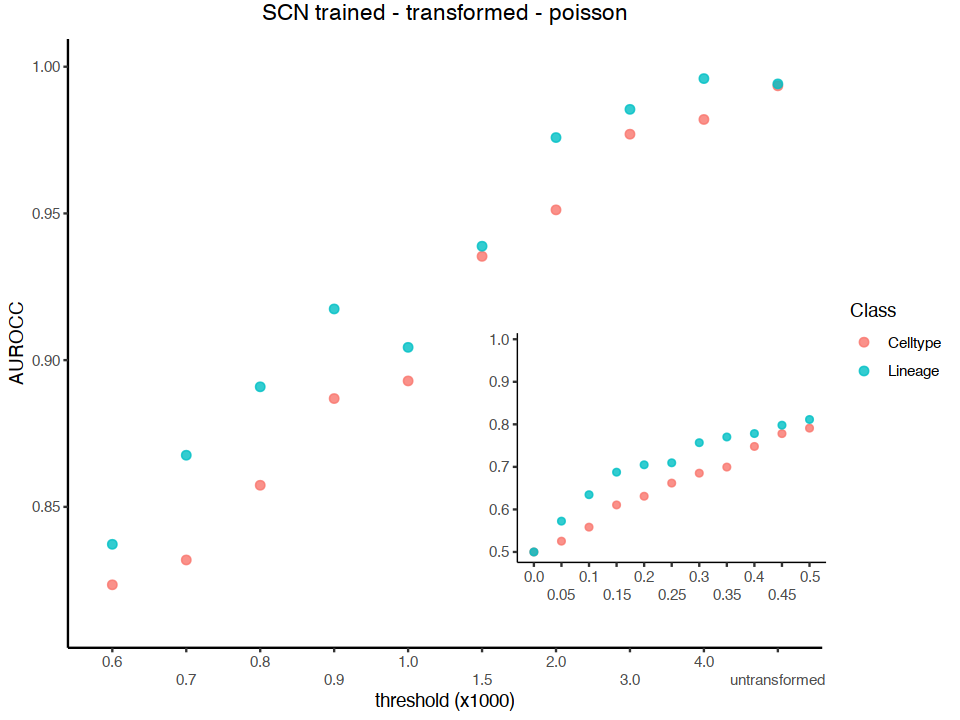

In [228]:
train = perf.SCN
train.name <- 'SCN trained'
method = 'poisson'
threshold <- as.factor(train$threshold)
AUC_pROC <- as.numeric(train$AUC_pROC)
data <- train[train$method == method,]
data <- data[order(data$AUC_pROC),]

main.levels <- levels(threshold)[12:length(levels(threshold))]  #c('0.6','0.7','0.8','0.9','1.0','1.5','2.0','3.0','4.0','untransformed')
inset.levels <- levels(threshold)[1:11] #c('0.0','0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5')

plot <- ggplot(data, aes(threshold, AUC_pROC )) + 
            theme_classic() + 
            theme(plot.title = element_text(vjust = 2, hjust = 0.5)) # center plot title

    main.plot <- plot +       
                geom_point(aes(color = as.factor(class)), size = 2, alpha = 0.8) + 
                scale_x_discrete(guide=guide_axis(n.dodge=2), breaks=main.levels, limits=main.levels) +
                ylim(min(data$AUC_pROC[22:42]), 1.0) +
                xlab("threshold (x1000)") + ylab("AUROCC") + labs(color='Class')  +
                ggtitle(paste(train.name, "transformed", method, sep =' - ')) 


    inset.plot <- plot + 
                geom_point(aes(color = as.factor(class)), size = 1.5, alpha = 0.8) + 
                scale_x_discrete(guide=guide_axis(n.dodge=2), breaks=inset.levels, limits=inset.levels) +
                ylim(min(data$AUC_pROC[2:22]), max(AUC_pROC[2:22]) )+
                theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank(), axis.line = element_line( size = 0.3))
                

 ggdraw() +
  draw_plot(main.plot ) +
  draw_plot(inset.plot, x = 0.5, y = .15, width = .37, height = .4)

  options(repr.plot.width=8, repr.plot.height=6)


In [223]:


data <- data[order(data$AUC_pROC),]
data[22:42,]


,V1,class,source,threshold,method,AUC_SCN,AUC_pROC,VnCells,nTopGenes,Avg.Reads,Avg.Genes
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
116,11,Lineage,reads,0.5,poisson,0.9025617,0.8113975,400,100,500,247
96,12,Celltype,reads,0.6,poisson,0.8195589,0.8234373,400,100,593,294
97,13,Celltype,reads,0.7,poisson,0.8498593,0.8319030,400,100,699,338
117,12,Lineage,reads,0.6,poisson,0.9326372,0.8372414,400,100,593,291
98,14,Celltype,reads,0.8,poisson,0.8747157,0.8573637,400,100,801,380
118,13,Lineage,reads,0.7,poisson,0.9506659,0.8675980,400,100,704,335
99,15,Celltype,reads,0.9,poisson,0.9006060,0.8869137,400,100,899,421
119,14,Lineage,reads,0.8,poisson,0.9592918,0.8909120,400,100,791,377
100,16,Celltype,reads,1.0,poisson,0.9202812,0.8929133,400,100,1004,462


In [5]:
mean.v = -22
median.v = -20
mean.median.h = 22.5
# show reads and genes distribution, mean and median 
statplot <- function(method){
    if (method == 'binary'){
        table_type <- 'genes'
        dist.reads.data <- dist.reads_binary
        dist.genes.data <- dist.genes_binary
        stats.reads.data <- stat.reads_binary
        stats.genes.data <- stat.genes_binary

        } else if (method == 'poisson'){
        table_type <- 'reads'
        dist.reads.data <- dist.reads_poisson
        dist.genes.data <- dist.genes_poisson
        stats.reads.data <- stat.reads_poisson
        stats.genes.data <- stat.genes_poisson


        } else if (method == 'non-binary'){
        table_type <- 'genes'
        dist.reads.data <- dist.reads_nonbin
        dist.genes.data <- dist.genes_nonbin
        stats.reads.data <- stat.reads_nonbin
        stats.genes.data <- stat.genes_nonbin
        }
    # reads distribution plot 
    plot1 <- ggplot(dist.reads.data, aes(Var2, value)) + 
                geom_boxplot() + 
                stat_summary(fun= mean, colour="darkred", geom="point", shape=18, size=2, show.legend=FALSE) + # mean figure
                geom_text(data = stats.reads.data, aes(label = Mean, y =  10), vjust= mean.v, size = 3, colour="darkred") +  # mean data
                geom_text(data = stats.reads.data, aes(label = median, y =  10), vjust= median.v, size = 3, colour="black") +  # median data 
                # geom_text(x=mean.median.h , y = mean.v, label="Mean", colour="darkred", size = 3, vjust = mean.v ) +  # mean label
                # geom_text(x=mean.median.h , y = median.v, label="Median", colour="black", size = 3, vjust = median.v) +  # median label

               # ggtitle(paste("Post-transformation nReads observed -", method)) +
                xlab(paste('number of', table_type, 'threshold (x1000)'))  + ylab("number of reads observed") + 
                scale_x_discrete(guide=guide_axis(n.dodge=2)) +
                theme_classic() +
                theme(plot.title = element_text(vjust = 9, hjust = 0.5), # title centered & up to accomodate stats annotations
                    axis.title=element_text(size= 9,face="bold")) + # adjust axis label sizes
                coord_cartesian(clip = "off")+
            theme(plot.margin = unit(c(0,1.5,0.5,0.5), "cm"))

    # genes distribution plot 
    plot2 <- ggplot(dist.genes.data, aes(as.factor(Var2), value)) + 
            geom_boxplot() + 
            stat_summary(fun= mean, colour="darkred", geom="point", shape=18, size=2, show.legend=FALSE) + # mean figure
            geom_text(data = stats.genes.data, aes(label = Mean, y =  10), vjust= mean.v, size = 3, colour="darkred") +  # mean data 
            geom_text(data = stats.genes.data, aes(label = median, y =  10), vjust= median.v, size = 3, colour="black") +  # median data 
            # geom_text(x=mean.median.h , y = mean.v, label="Mean", colour="darkred", size = 3, vjust = mean.v ) +  # mean label
            # geom_text(x=mean.median.h , y = median.v, label="Median", colour="black", size = 3, vjust = median.v) +  # median label
          #  ggtitle(paste("Post-transformation nGenes observed -", method)) +
            xlab(paste('number of', table_type, 'threshold (x1000)')) + ylab("number of genes observed") + 
            scale_x_discrete(guide=guide_axis(n.dodge=2)) +
            theme_classic() +
            theme(plot.title = element_text(vjust = 9, hjust = 0.5), # title centered & up to accomodate stats annotations
                axis.title=element_text(size= 9,face="bold") ) + 
            coord_cartesian(clip = "off") +
            theme(plot.margin = unit(c(0,1.5,0.5,0.5), "cm"))

    spacer <- NULL
    ggarrange(grobs = spacer, plot1, spacer, plot2, ncol = 1, nrow = 4, heights=c(20, 100, 20, 100)) 
}
plot1 <- statplot('poisson')
plot2 <- statplot('non-binary')
plot3 <- statplot('binary')

pdf('Figures/Fig.3c.pdf', width = 9, height = 6)
plot1
dev.off()

pdf('Figures/Supp.1c.pdf', width = 9, height = 6)
plot2
dev.off()

pdf('Figures/Supp.2c.pdf', width = 9, height = 6)
plot3
dev.off()

options(repr.plot.width=9, repr.plot.height=6)


pdf 
  2

pdf 
  2

pdf 
  2

In [6]:
# Figure 5

setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(tidyverse)
library(qs)

# data
meta_sub_LQ <- fread('metadata_subsample_LQ_no_id.txt', sep='\t', data.table=F) # low quality subsample metadata
meta_sub_HQ <- fread('metadata_subsample_HQ_no_id.txt', sep='\t', data.table=F) # high quality subsample metadata

meta_sub <- bind_rows(meta_sub_HQ, meta_sub_LQ) # combine HQ & LQ metadata


## indexing 
# Lineage
epi.ind <- which(meta_sub$Lineage == "Epithelial_cells")
mes.ind <- which(meta_sub$Lineage == "Stromal_cells")
hem.ind <- which(meta_sub$Lineage == "Immune_cells")

# LQ cell type labels
tcell.ind.LQ <- which( meta_sub$hpca == "T_cells" )
bcell.ind.LQ <- which( meta_sub$hpca == "B_cell" )
macro.ind.LQ <- which( meta_sub$hpca == "Macrophage" | meta_sub$hpca == "Monocyte")
fibro.ind.LQ <- which( meta_sub$hpca == "Fibroblasts")

# LQ cell type labels
tcell.ind.HQ <- which( meta_sub$Celltype == "T cells" )
bcell.ind.HQ <- which( meta_sub$Celltype == "B cells" )
macro.ind.HQ <- which( meta_sub$Celltype == "Macrophages")
fibro.ind.HQ <- which( meta_sub$Celltype == "Fibroblasts")

# combined cell type labels
tcell.ind <- c(tcell.ind.LQ, tcell.ind.HQ)
bcell.ind <- c(bcell.ind.LQ, bcell.ind.HQ)
macro.ind <- c(macro.ind.LQ, macro.ind.HQ)
fibro.ind <- c(fibro.ind.LQ, fibro.ind.HQ)


## setting cut-offs
## JF's cut-off for FELINE_C1: > 2000 UMI. 500 - 7000 genes 
nCount_RNA_cutoff <- 1500
new.nCount_RNA_cutoff <- 450

pre.retained.all <- length(which(meta_sub$nCount_RNA > nCount_RNA_cutoff))
post.retained.all <- length(which(meta_sub$nCount_RNA < nCount_RNA_cutoff & meta_sub$nCount_RNA > new.nCount_RNA_cutoff))

pre.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] > nCount_RNA_cutoff))
post.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[epi.ind] > new.nCount_RNA_cutoff))

pre.retained.mes <- length(which(meta_sub$nCount_RNA[mes.ind] > nCount_RNA_cutoff))
post.retained.mes <- length(which(meta_sub$nCount_RNA[mes.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[mes.ind] > new.nCount_RNA_cutoff))

pre.retained.hem <- length(which(meta_sub$nCount_RNA[hem.ind] > nCount_RNA_cutoff))
post.retained.hem <- length(which(meta_sub$nCount_RNA[hem.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[hem.ind] > new.nCount_RNA_cutoff))


pre.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] > nCount_RNA_cutoff))
post.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[fibro.ind] > new.nCount_RNA_cutoff))

pre.retained.bcell <- length(which(meta_sub$nCount_RNA[bcell.ind] > nCount_RNA_cutoff))
post.retained.bcell <- length(which(meta_sub$nCount_RNA[bcell.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[bcell.ind] > new.nCount_RNA_cutoff))

pre.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] > nCount_RNA_cutoff))
post.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[tcell.ind] > new.nCount_RNA_cutoff))

pre.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] > nCount_RNA_cutoff))
post.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[macro.ind] > new.nCount_RNA_cutoff))



In [7]:

options(repr.plot.width=14, repr.plot.height=6)

title.size <- 1.4
lab.size <- 1.0
sub.size <- 1.4


## Plot number of reads and genes by lineage
pdf('Figures/Fig.5a.pdf', width = 14, height = 6)
par(mfrow=c(2,4), mar=c(6,5,5,1))

plot(main = "All cells: total reads (log10)", density(log10(meta_sub$nCount_RNA)), , cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -17.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.all/pre.retained.all),'%', '( n =', post.retained.all, ')' ))  # subtitle

plot(main = "Epithelial cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[epi.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -17.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.epi/pre.retained.epi),'%', '( n =', post.retained.epi, ')' ))  # subtitle

plot(main = "Stromal_cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[mes.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -17.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.mes/pre.retained.mes),'%', '( n =', post.retained.mes, ')' ))  # subtitle

plot(main = "Immune_cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[hem.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -17.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.hem/pre.retained.hem),'%', '( n =', post.retained.hem, ')' ))  # subtitle

plot(main = "Fibroblasts: total reads (log10)", density(log10(meta_sub$nCount_RNA[fibro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line=  -17.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.fibro/pre.retained.fibro),'%', '( n =', post.retained.fibro, ')' ))  # subtitle

plot(main = "B.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[bcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line=  -17.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.bcell/pre.retained.bcell),'%', '( n =', post.retained.bcell, ')' ))  # subtitle

plot(main = "T.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[tcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line=  -17.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.tcell/pre.retained.tcell),'%', '( n =', post.retained.tcell, ')' ))  # subtitle

plot(main = "Macrophages: total reads (log10)", density(log10(meta_sub$nCount_RNA[macro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -17.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.macro/pre.retained.macro),'%', '( n =', post.retained.macro, ')' ))  # subtitle

dev.off()




pdf 
  2

In [12]:
# Figure 4

library(qs)
library(Seurat)
library(singleCellNet)

setwd('/Users/ibishara/Desktop/FELINE_C1/')

seu_HQ <- qread(file = "seu_HQ_no_id.qs")
seu_HQ <- subset(x = seu_HQ, subset = Celltype != "Normal epithelial cells")   ## Removes normal epithelial cells. Genes unique to normal epi cells are removed from analysis downstream
seu_HQ <- subset(seu_HQ, subset = nCount_RNA < 15000 ) 
##


red.reads <- function(x, y){
    x <- round(x * rpois(n=length(x), lambda=y/sum(x)))
    return(x)
    }

meta <- seu_HQ@meta.data
seu.HQ.counts <- GetAssayData(seu_HQ, assay = "RNA")


umap_transformed <- function(class, i){

    # Split 50 / 50 
    ncells <- 3000
    stList = splitCommon(sampTab = meta, ncells = ncells, dLevel = class)
    stSub = stList[[1]]
    stTrain = stSub[sample(nrow(stSub), round(nrow(stSub)/2)), ]
    stTest = stSub[! rownames(stSub) %in% rownames(stTrain) ,]
    counts = seu.HQ.counts[ , rownames(stTest)]

    transformed <- apply(X = counts, MARGIN = 2, FUN = red.reads, y = i) # run 2nd function to reduce the number of count per cell above threshold. iterates over columns (cells)
    meta_transformed <- meta[colnames(transformed), ]
    seu_HQ_transformed <- CreateSeuratObject(counts= transformed, min.features= 0, min.cells = 0, names.delim= "_", meta.data= meta_transformed) 

    ## Normalize and scale 

    seu_HQ_transformed <- NormalizeData(seu_HQ_transformed, verbose = FALSE)
    seu_HQ_transformed <- FindVariableFeatures(seu_HQ_transformed, verbose = FALSE)
    genes <- rownames(seu_HQ_transformed)
    seu_HQ_transformed <- ScaleData(seu_HQ_transformed, features = genes, verbose = FALSE)
    seu_HQ_transformed <- RunPCA(seu_HQ_transformed, features = VariableFeatures(object = seu_HQ_transformed), verbose = FALSE)
    ElbowPlot(seu_HQ_transformed, ndims = 50)

    ## Cell clustering
    seu_HQ_transformed <- FindNeighbors(seu_HQ_transformed, dims = 1:10, verbose = FALSE) 
    seu_HQ_transformed <- FindClusters(seu_HQ_transformed, resolution = 0.1, verbose = FALSE)

    ## UMAP
    seu_HQ_transformed <- RunUMAP(seu_HQ_transformed, dims = 1:10, verbose = FALSE)
    DimPlot(seu_HQ_transformed, reduction = "umap", group.by = class) + ggtitle(i)
}



In [18]:
library(parallel)
library(patchwork)

numCores <- detectCores()

celltype <- mclapply(c(450, 350, 250, 150),
             FUN=function(i) umap_transformed('Celltype', i) + ggtitle(i),
             mc.cores = numCores)

lineage <- mclapply(c(450, 350, 250, 150),
             FUN=function(i) umap_transformed('Lineage', i) + ggtitle(i),
             mc.cores = numCores)



In [19]:
combined.lineage <- lineage[[1]]+ lineage[[2]] + lineage[[3]] + lineage[[4]] & theme(legend.position = "right") 
combined.celltype <- celltype[[1]]+ celltype[[2]] + celltype[[3]] + celltype[[4]] & theme(legend.position = "right") 

pdf('Figures/Fig.4a.pdf', width = 14, height = 4)
    combined.lineage + plot_layout(guides = "collect", ncol =4)
dev.off()

pdf('Figures/Fig.4b.pdf', width = 14, height = 4)
    combined.celltype + plot_layout(guides = "collect", ncol =4)
dev.off()



pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

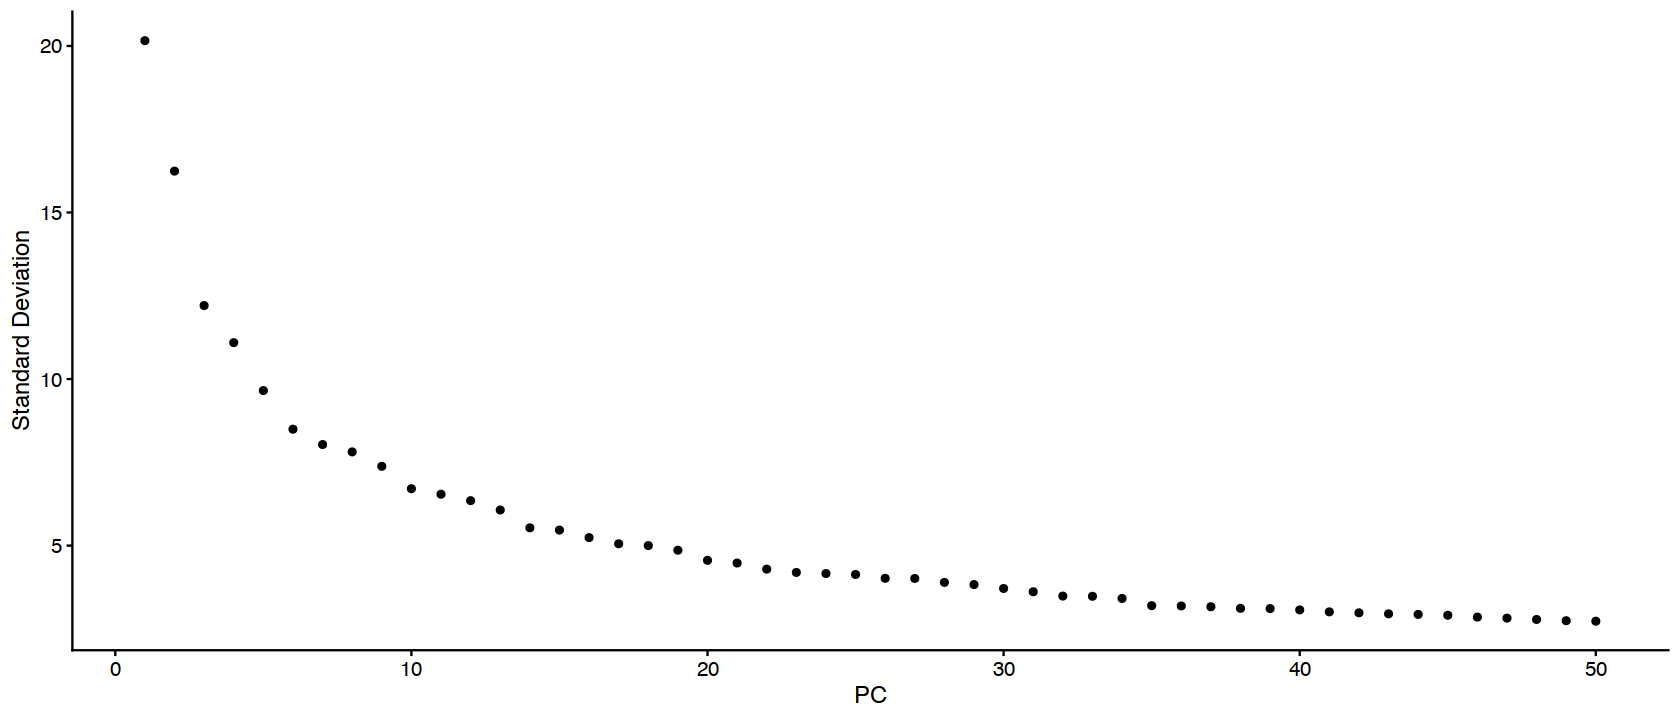

In [11]:
# Figure 3 supplement 

library(qs)
library(Seurat)

## Generate UMAP for untransformed HQ
seu_HQ <- qread(file = "seu_HQ_no_id.qs")
seu_HQ <- subset(x = seu_HQ, subset = Celltype != "Normal epithelial cells")   ## Removes normal epithelial cells. Genes unique to normal epi cells are removed from analysis downstream
seu_HQ <- subset(seu_HQ, subset = nCount_RNA < 15000 ) 

## Normalize and scale 
seu_HQ <- NormalizeData(seu_HQ, verbose = FALSE)
genes <- rownames(seu_HQ)
seu_HQ <- ScaleData(seu_HQ, features = genes, verbose = FALSE)
seu_HQ <- RunPCA(seu_HQ, features = genes, verbose = FALSE)
# ElbowPlot(seu_HQ, ndims = 50)

## Cell clustering
seu_HQ <- FindNeighbors(seu_HQ, dims = 1:20, verbose = FALSE) 
seu_HQ <- FindClusters(seu_HQ, resolution = 0.1, verbose = FALSE)

## UMAP
seu_HQ <- RunUMAP(seu_HQ, dims = 1:20, verbose = FALSE)

pdf('Figures/Supp.3a.pdf', width = 6, height = 4)
    DimPlot(seu_HQ, reduction = "umap", group.by = 'Celltype') 
dev.off()

pdf('Figures/Supp.3b.pdf', width = 6, height = 4)
    DimPlot(seu_HQ, reduction = "umap", group.by = 'Lineage') 
dev.off()

options(repr.plot.width=4, repr.plot.height=6)


